<h1 style='color:purple' align='center'>Exploratory Data Analysis Project: Loan Defaulter Detection</h1>

Dataset is downloaded from here: https://www.kaggle.com/datasets/prakashraushan/loan-dataset

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_scoreroc_curve, auc
import xgboost as xgb

<h2 style='color:green'>Data Load: Loading Loan Distribution Data into a dataframe</h2>

In [178]:
# Load the dataset
df = pd.read_csv('LoanDataset.csv') 


# View the first few rows
print(df.head())

# Summary
print(df.describe())
df.shape


   customer_id  customer_age customer_income home_ownership  \
0          1.0            22           59000           RENT   
1          2.0            21            9600            OWN   
2          3.0            25            9600       MORTGAGE   
3          4.0            23           65500           RENT   
4          5.0            24           54400           RENT   

   employment_duration loan_intent loan_grade   loan_amnt  loan_int_rate  \
0                123.0    PERSONAL          C  £35,000.00          16.02   
1                  5.0   EDUCATION          A   £1,000.00          11.14   
2                  1.0     MEDICAL          B   £5,500.00          12.87   
3                  4.0     MEDICAL          B  £35,000.00          15.23   
4                  8.0     MEDICAL          B  £35,000.00          14.27   

   term_years historical_default  cred_hist_length Current_loan_status  
0          10                  Y                 3             DEFAULT  
1           1     

(32586, 13)

<h2 style='color:green'>Data Cleaning: Handling NA values</h2>

In [179]:
# Check for missing values
print(df.isnull().sum())



customer_id                3
customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  1
loan_int_rate           3116
term_years                 0
historical_default     20737
cred_hist_length           0
Current_loan_status        4
dtype: int64


As there are too many NA Values in my data, I will replace Historical_defaukt to NO, Loan interest rate to the average

In [180]:
df['historical_default'].replace('NO DEFAULT', 'N', inplace=True)
df['historical_default'].fillna('N', inplace=True)


df['loan_int_rate'].fillna(df['loan_int_rate'].mean(), inplace=True)

# Check for remaining missing values
print(df.isnull().sum())



customer_id              3
customer_age             0
customer_income          0
home_ownership           0
employment_duration    895
loan_intent              0
loan_grade               0
loan_amnt                1
loan_int_rate            0
term_years               0
historical_default       0
cred_hist_length         0
Current_loan_status      4
dtype: int64


C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\70127700.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['historical_default'].replace('NO DEFAULT', 'N', inplace=True)
C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\70127700.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

We can now just drop the others

In [181]:

encoded_df = df.dropna()  # Simple approach: drop rows with any missing values
encoded_df.shape


(31683, 13)

<h2 style='color:green'>Feature Engineering</h2>
 Remove non-numeric characters and commas from numerical columns

In [182]:
numerical_columns_with_symbols = ['customer_income', 'loan_amnt']

for column in numerical_columns_with_symbols:
    encoded_df[column] = encoded_df[column].apply(lambda x: re.sub(r'[^\d.]', '', str(x))).astype(float)

C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\3794981469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_df[column] = encoded_df[column].apply(lambda x: re.sub(r'[^\d.]', '', str(x))).astype(float)
C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\3794981469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_df[column] = encoded_df[column].apply(lambda x: re.sub(r'[^\d.]', '', str(x))).astype(float)


In [183]:

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default', 'Current_loan_status']

for column in categorical_columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])




C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\3559206960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\3559206960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
C:\Users\hskma\AppData\Local\Temp\ipykernel_15748\3559206960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Now I am  plotting Numerical Features to see for what range, number of loan is higher. Which will remove most of the Outliers.

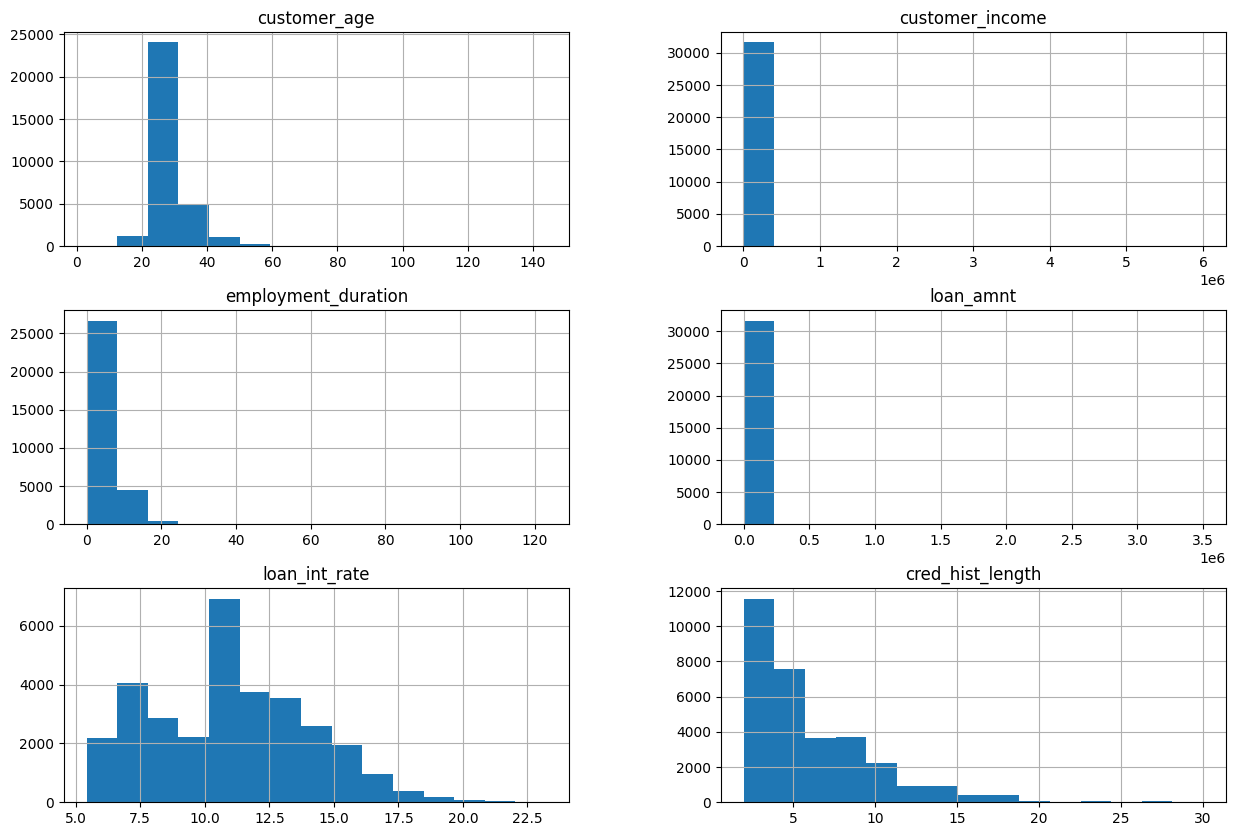

In [184]:
# Distribution of numerical features
numerical_features = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'cred_hist_length']
encoded_df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.show()


We can see following relevant features ranges from the Histograms :-

1. Customer Age         - 10 to 60 years old
2. Customer Income      - 0 to 500,000
3. Employment Duration  - 0 to 30 years
4. Loan Amount          - 0 to 300,000
5. Credit History Lenth - 1 to 20


In [185]:
# Filter rows where customer_age is between 10 and 60
encoded_df = encoded_df[(encoded_df['customer_age'] >= 10) & (encoded_df['customer_age'] <= 60)]

# Filter rows where employment_duration is between 0 and 30 years
encoded_df = encoded_df[(encoded_df['employment_duration'] >= 0) & (encoded_df['employment_duration'] <= 30)]

# Filter rows where cred_hist_length is between 1 and 20
encoded_df = encoded_df[(encoded_df['cred_hist_length'] >= 1) & (encoded_df['cred_hist_length'] <= 20)]

# Filter rows where customer_income is between 0 and 500000
encoded_df = encoded_df[(encoded_df['customer_income'] >= 0) & (encoded_df['customer_income'] <= 250000)]

# Filter rows where loan_amnt is between 0 and 300000
encoded_df = encoded_df[(encoded_df['loan_amnt'] >= 0) & (encoded_df['loan_amnt'] <= 200000)]


encoded_df.shape


(31226, 13)

Plotting Again to check

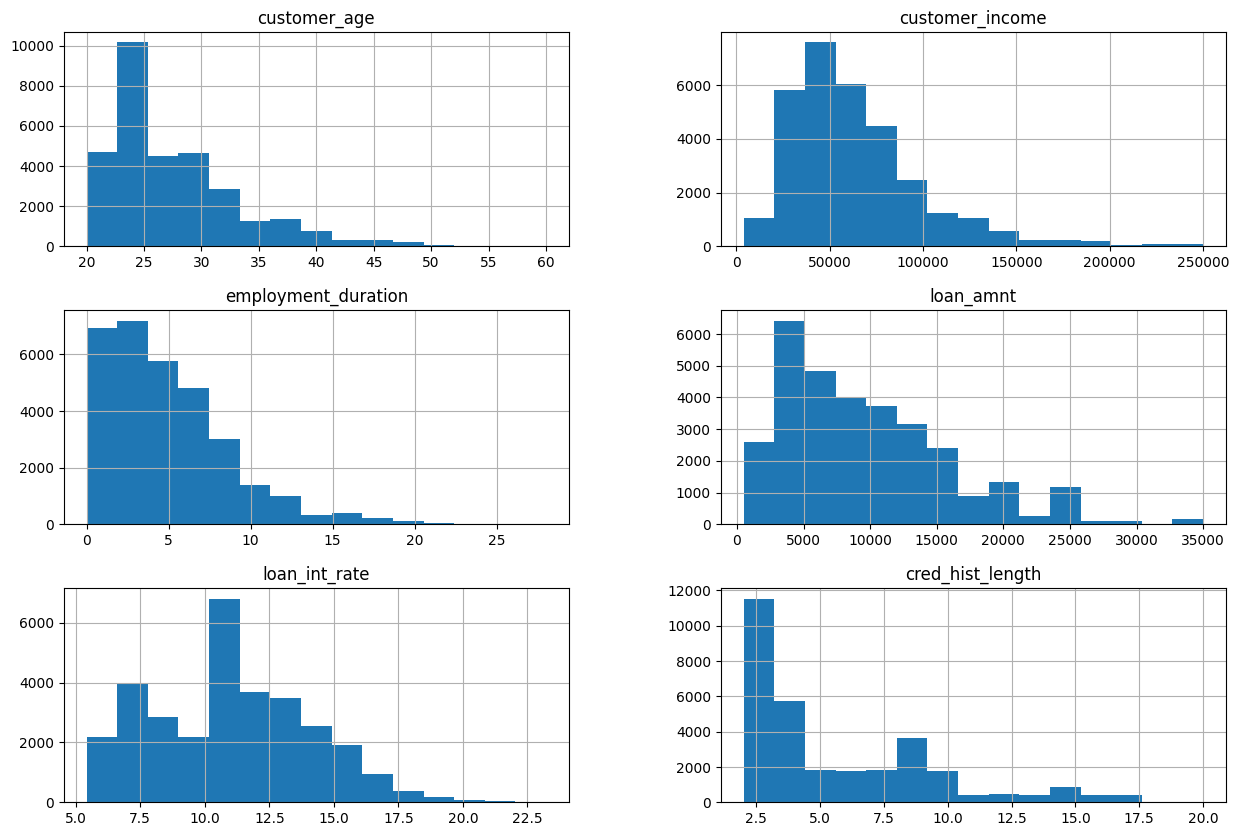

In [186]:
# Distribution of numerical features
numerical_features = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'cred_hist_length']
encoded_df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.show()


Everything Worked great. Now i will plot all Categorical Features againts Numerical Numerical, to see current loan status

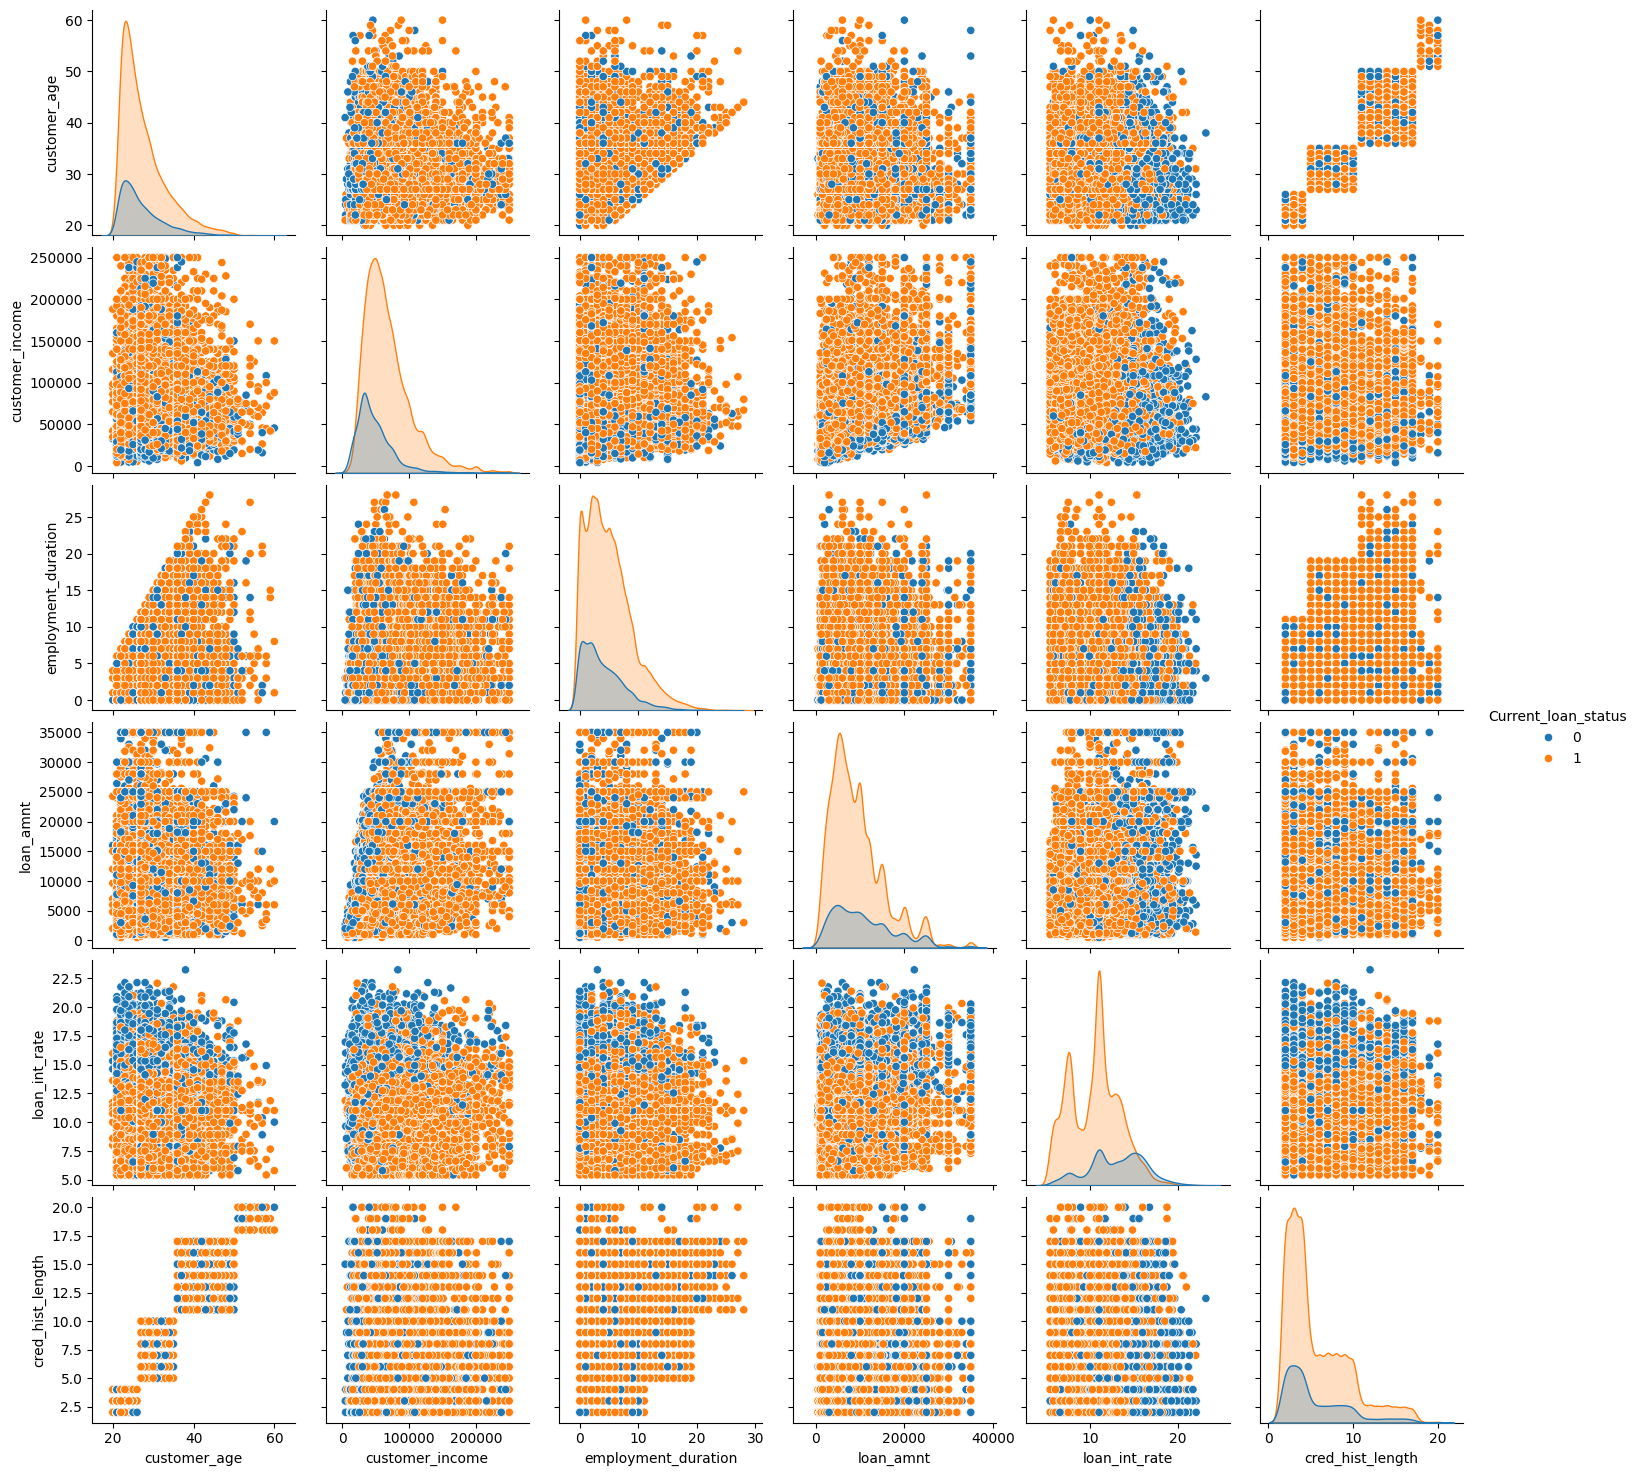

In [187]:
#Pair Plot
sns.pairplot(encoded_df, hue='Current_loan_status', vars=numerical_features)
plt.show()


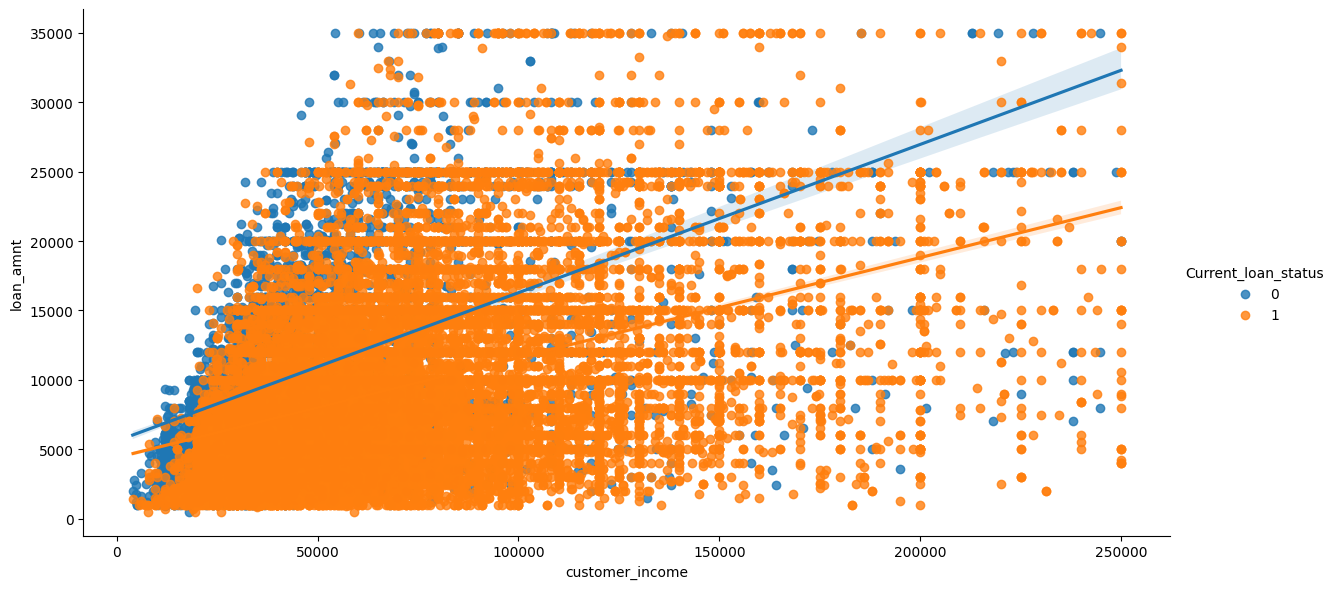

In [188]:
#Feature Interaction
sns.lmplot(x='customer_income', y='loan_amnt', hue='Current_loan_status', data=encoded_df, aspect=2, height=6)
plt.show()


<h2 style='color:orange'>Building a Model with Random Forest Classifier...</h2>

In [195]:

X = encoded_df[numerical_features]
y = encoded_df['Current_loan_status']  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training with RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Model evaluation
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')

# Hyperparameter tuning with GridSearchCV for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train_scaled, y_train)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb)}')


              precision    recall  f1-score   support

           0       0.75      0.55      0.63      1290
           1       0.89      0.95      0.92      4956

    accuracy                           0.87      6246
   macro avg       0.82      0.75      0.78      6246
weighted avg       0.86      0.87      0.86      6246

ROC-AUC Score: 0.7495312236049326
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1290
           1       0.89      0.95      0.92      4956

    accuracy                           0.87      6246
   macro avg       0.81      0.75      0.77      6246
weighted avg       0.86      0.87      0.86      6246

ROC-AUC Score: 0.7501417121834938


<h2 style='color:orange'>Now Plotting ROC and F-Score Graphs</h2>

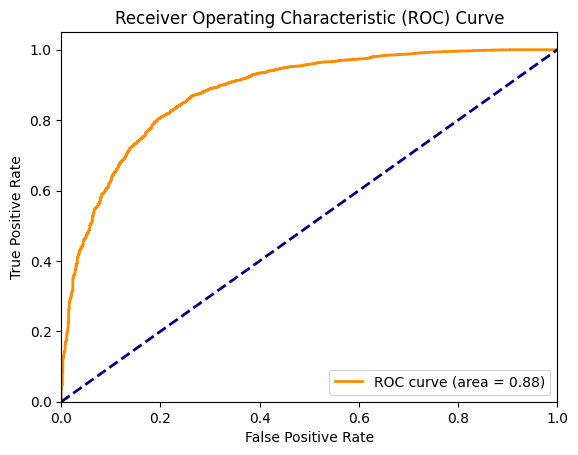

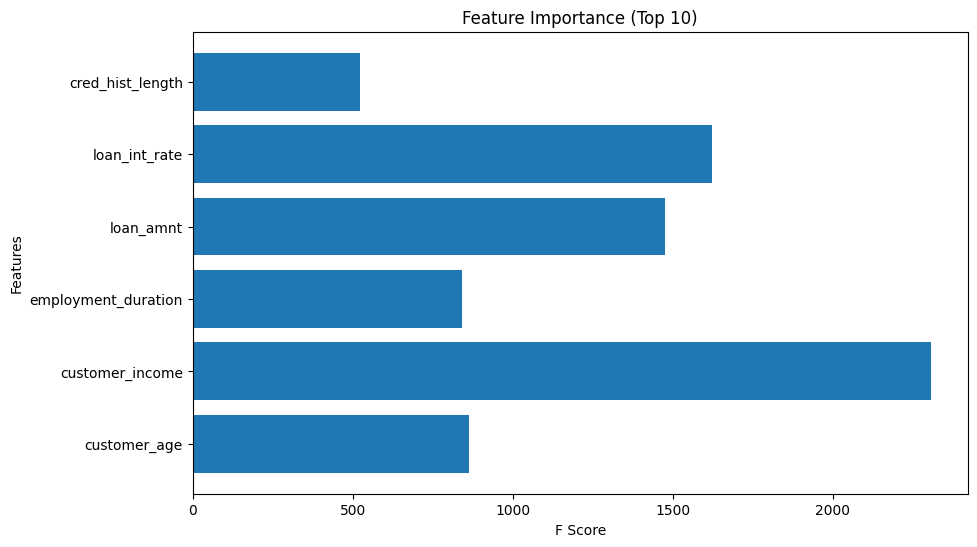

In [193]:

# Plotting the ROC Curve for the best XGBoost model
y_pred_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting feature importance for the best XGBoost model with feature names
feature_importance = best_xgb.get_booster().get_score(importance_type='weight')
features = [numerical_features[int(f[1:])] for f in feature_importance.keys()]
importances = list(feature_importance.values())

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('F Score')
plt.ylabel('Features')
plt.title('Feature Importance (Top 10)')
plt.show()

<h2 style='color:green'>Conclusion</h2>

1. The model's ROC curve is well above the diagonal line, indicating it performs significantly better than random guessing.
2. An AUC of 0.88 suggests that the model has a high ability to distinguish between the default and no default cases.
3. The feature importance plot indicates which features are most influential in the model's predictions, with CUSTOMER INCOME  being the most important feature in this case.